In [1]:
import pandas as pd
import numpy as np
import re
import json
import gensim
import math
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import KeyedVectors
#import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D
import h5py

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dhanyaharish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dhanyaharish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2021-12-04 12:14:23.251088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2021-12-04 12:14:23.251113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)
data =list(parse_data('/home/dhanyaharish/Documents/GitHub/NLP/Sarcasm_Headlines_Dataset_v2.json'))
df = pd.DataFrame(data)


In [37]:
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [3]:
df.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df.pop('article_link')

0        https://www.theonion.com/thirtysomething-scien...
1        https://www.huffingtonpost.com/entry/donna-edw...
2        https://www.huffingtonpost.com/entry/eat-your-...
3        https://local.theonion.com/inclement-weather-p...
4        https://www.theonion.com/mother-comes-pretty-c...
                               ...                        
28614    https://www.theonion.com/jews-to-celebrate-ros...
28615    https://local.theonion.com/internal-affairs-in...
28616    https://www.huffingtonpost.com/entry/andrew-ah...
28617    https://www.theonion.com/mars-probe-destroyed-...
28618    https://www.theonion.com/dad-clarifies-this-no...
Name: article_link, Length: 28619, dtype: object

In [5]:
import string
from string import digits, punctuation

hl_cleansed = []
for hl in df['headline']:
#     Remove punctuations
    clean = hl.translate(str.maketrans('', '', punctuation))
#     Remove digits/numbers
    clean = clean.translate(str.maketrans('', '', digits))
    hl_cleansed.append(clean)
    
# View comparison
print('Original texts :')
print(df['headline'][37])
print('\nAfter cleansed :')
print(hl_cleansed[37])

Original texts :
stars with gray hair prove getting older isn't all that bad

After cleansed :
stars with gray hair prove getting older isnt all that bad


In [6]:
# Tokenization process
hl_tokens = []
for hl in hl_cleansed:
    hl_tokens.append(hl.split())

# View Comparison
index = 100
print('Before tokenization :')
print(hl_cleansed[index])
print('\nAfter tokenization :')
print(hl_tokens[index])

Before tokenization :
report  of trump endorsements made after staring at bedroom ceiling for  hours

After tokenization :
['report', 'of', 'trump', 'endorsements', 'made', 'after', 'staring', 'at', 'bedroom', 'ceiling', 'for', 'hours']


In [8]:
# Lemmatize with appropriate POS Tag
# Credit : www.machinelearningplus.com/nlp/lemmatization-examples-python/

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

hl_lemmatized = []
for tokens in hl_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    hl_lemmatized.append(lemm)
    
# Example comparison
word_1 = ['skyrim','dragons', 'are', 'having', 'parties']
word_2 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_1]
print('Before lemmatization :\t',word_1)
print('After lemmatization :\t',word_2)

Before lemmatization :	 ['skyrim', 'dragons', 'are', 'having', 'parties']
After lemmatization :	 ['skyrim', 'dragon', 'be', 'have', 'party']


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Vectorize and convert text into sequences
max_features = 2000
max_token = len(max(hl_lemmatized))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_lemmatized)
sequences = tokenizer.texts_to_sequences(hl_lemmatized)
X = pad_sequences(sequences, maxlen=max_token)

In [10]:
index = 10
print('Before :')
print(hl_lemmatized[index],'\n')
print('After sequences convertion :')
print(sequences[index],'\n')
print('After padding :')
print(X[index])

Before :
['this', 'lesbian', 'be', 'consider', 'a', 'father', 'in', 'indiana', 'and', 'an', 'amaze', 'one', 'at', 'that'] 

After sequences convertion :
[23, 5, 904, 6, 319, 4, 9, 70, 885, 47, 17, 26] 

After padding :
[  0   0  23   5 904   6 319   4   9  70 885  47  17  26]


In [11]:
from sklearn.model_selection import train_test_split

Y = df['is_sarcastic'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

In [13]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
#from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embed_dim = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 64)            128000    
                                                                 
 lstm (LSTM)                 (None, 96)                61824     
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 189,921
Trainable params: 189,921
Non-trainable params: 0
_________________________________________________________________
None


2021-12-04 12:18:01.954329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2021-12-04 12:18:01.954390: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-04 12:18:01.954437: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-Laptop-15-da0xxx-def03a20): /proc/driver/nvidia/version does not exist
2021-12-04 12:18:01.955073: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
epoch = 10
batch_size = 128
model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2)

Epoch 1/10
157/157 - 7s - loss: 0.5186 - accuracy: 0.7265 - 7s/epoch - 44ms/step
Epoch 2/10
157/157 - 4s - loss: 0.3560 - accuracy: 0.8431 - 4s/epoch - 26ms/step
Epoch 3/10
157/157 - 4s - loss: 0.3249 - accuracy: 0.8583 - 4s/epoch - 26ms/step
Epoch 4/10
157/157 - 4s - loss: 0.3055 - accuracy: 0.8672 - 4s/epoch - 26ms/step
Epoch 5/10
157/157 - 4s - loss: 0.2885 - accuracy: 0.8746 - 4s/epoch - 25ms/step
Epoch 6/10
157/157 - 4s - loss: 0.2693 - accuracy: 0.8833 - 4s/epoch - 24ms/step
Epoch 7/10
157/157 - 6s - loss: 0.2557 - accuracy: 0.8898 - 6s/epoch - 37ms/step
Epoch 8/10
157/157 - 4s - loss: 0.2576 - accuracy: 0.8888 - 4s/epoch - 25ms/step
Epoch 9/10
157/157 - 6s - loss: 0.2340 - accuracy: 0.8967 - 6s/epoch - 40ms/step
Epoch 10/10
157/157 - 4s - loss: 0.2162 - accuracy: 0.9044 - 4s/epoch - 27ms/step


In [15]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)
print("Overall scores")
print("Loss\t\t: ", round(loss, 3))
print("Accuracy\t: ", round(acc, 3))

269/269 - 1s - loss: 0.5793 - accuracy: 0.8215 - 975ms/epoch - 4ms/step
Overall scores
Loss		:  0.579
Accuracy	:  0.821


In [16]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.around(result) == np.around(Y_test[x]):
        if np.around(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.around(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

1/1 - 0s - 244ms/epoch - 244ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 1

In [ ]:
https://www.kaggle.com/wflazuardy/sarcasm-detection-with-keras-preprocessing

In [17]:
# Importing required libraries
import json
import tensorflow as tf
import requests
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Get the dataset
srcsm_json = requests.get('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json')
# Inspecting the data, print 450 characters
print(srcsm_json.text[0:450])

[
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0},


In [18]:
# Separate the json into sentences and labels
sentences = []
labels = []
for item in srcsm_json.json():
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
print(pd.DataFrame({'sentence' : sentences[0:10], 'label':labels[0:10]}))


                                            sentence  label
0  former versace store clerk sues over secret 'b...      0
1  the 'roseanne' revival catches up to our thorn...      0
2  mom starting to fear son's web series closest ...      1
3  boehner just wants wife to listen, not come up...      1
4  j.k. rowling wishes snape happy birthday in th...      0
5                        advancing the world's women      0
6     the fascinating case for eating lab-grown meat      0
7  this ceo will send your kids to school, if you...      0
8  top snake handler leaves sinking huckabee camp...      1
9  friday's morning email: inside trump's presser...      0


In [19]:
# Splitting the dataset into Train and Test
training_size = round(len(sentences) * .75)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]
# Setting tokenizer properties
vocab_size = 10000
oov_tok = "<oov>"
# Fit the tokenizer on Training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
# Setting the padding properties
max_length = 100
trunc_type='post'
padding_type='post'
# Creating padded sequences from train and test data
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [20]:
# Setting the model parameters
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 24)                408       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
# Training the model
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
626/626 - 2s - loss: 0.6655 - accuracy: 0.5831 - val_loss: 0.5869 - val_accuracy: 0.6386 - 2s/epoch - 3ms/step
Epoch 2/30
626/626 - 2s - loss: 0.4319 - accuracy: 0.8298 - val_loss: 0.3839 - val_accuracy: 0.8433 - 2s/epoch - 3ms/step
Epoch 3/30
626/626 - 2s - loss: 0.3070 - accuracy: 0.8780 - val_loss: 0.3517 - val_accuracy: 0.8519 - 2s/epoch - 2ms/step
Epoch 4/30
626/626 - 1s - loss: 0.2537 - accuracy: 0.9019 - val_loss: 0.3540 - val_accuracy: 0.8493 - 1s/epoch - 2ms/step
Epoch 5/30
626/626 - 1s - loss: 0.2194 - accuracy: 0.9160 - val_loss: 0.3450 - val_accuracy: 0.8577 - 1s/epoch - 2ms/step
Epoch 6/30
626/626 - 1s - loss: 0.1919 - accuracy: 0.9289 - val_loss: 0.3561 - val_accuracy: 0.8531 - 1s/epoch - 2ms/step
Epoch 7/30
626/626 - 2s - loss: 0.1705 - accuracy: 0.9378 - val_loss: 0.3644 - val_accuracy: 0.8553 - 2s/epoch - 3ms/step
Epoch 8/30
626/626 - 1s - loss: 0.1517 - accuracy: 0.9448 - val_loss: 0.3797 - val_accuracy: 0.8558 - 1s/epoch - 2ms/step
Epoch 9/30
626/626 - 2s 

In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

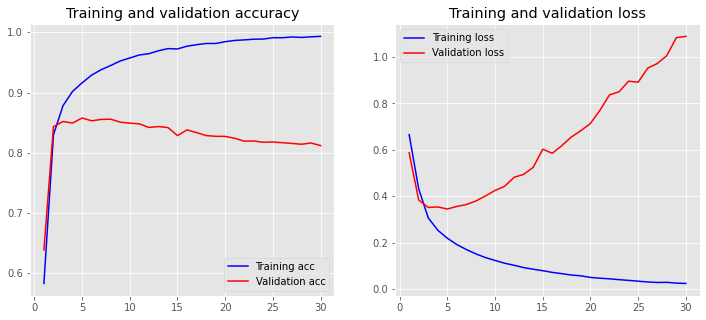

In [23]:
plot_history(history)

In [24]:
sentence = ["Coworkers At Bathroom Sink Locked In Tense Standoff Over Who Going To Wash Hands Longer", 
            "Spiking U.S. coronavirus cases could force rationing decisions similar to those made in Italy, China."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))


[[0.9996022 ]
 [0.02006271]]


# LSTM

In [25]:
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
file_path1 = '/home/dhanyaharish/Documents/GitHub/NLP/Sarcasm_Headlines_Dataset_v2.json'
df = pd.read_json(file_path1,lines=True)
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [28]:
headlines = df['headline'].values.tolist()
sarcastic = df['is_sarcastic'].values.tolist()

print('Length of data {}'.format(len(headlines)))

Length of data 28619


In [29]:
training_size = 20000
test_size = 8619

train_x = headlines[:training_size]
test_x = headlines[training_size:]
train_y = np.array(sarcastic[:training_size])
test_y = np.array(sarcastic[training_size:])

In [30]:
print(train_x[0])
print(train_y[0])

thirtysomething scientists unveil doomsday clock of hair loss
1


Now we will follow the following steps:

Tokenize the sentances.
Convert it to sequence.
Padding the sequences.

In [31]:
# vocab_size = 2000   #number of words in tokenizer
embedding_dim = 100
max_len = 16

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_x)

word_index = tokenizer.word_index
vocab_size = len(word_index)
sequence_train = tokenizer.texts_to_sequences(train_x)
seq_padd_train = pad_sequences(sequence_train,padding='post',truncating='post',maxlen=max_len)

#test
sequence_test = tokenizer.texts_to_sequences(test_x)
seq_padd_test = pad_sequences(sequence_test,padding='post',truncating='post',maxlen=max_len)

In [32]:
print(sequence_train[0])
print(seq_padd_train[0])
print(seq_padd_train.shape)

[12941, 325, 3169, 5817, 2489, 3, 655, 993]
[12941   325  3169  5817  2489     3   655   993     0     0     0     0
     0     0     0     0]
(20000, 16)


Now we will use transfer learning for creating an embedding matrix.

Download pretrained glove file
Create embedding dict
Create embedding matrix

In [33]:
embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs

In [34]:
# creating embedding matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len,weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    #return_sequences: will ensure output of first LSTM layer matches next
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 100)           2589900   
                                                                 
 bidirectional (Bidirectiona  (None, 16, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
 dropout (Dropout)           (None, 6)                

In [36]:
num_epochs = 20
history = model.fit(seq_padd_train, train_y , epochs=num_epochs, validation_data=(seq_padd_test,test_y))

Epoch 1/20
625/625 [==============================] - 19s 22ms/step - loss: 0.4940 - accuracy: 0.7646 - val_loss: 0.4133 - val_accuracy: 0.8043
Epoch 2/20
625/625 [==============================] - 11s 18ms/step - loss: 0.3758 - accuracy: 0.8411 - val_loss: 0.3304 - val_accuracy: 0.8538
Epoch 3/20
625/625 [==============================] - 11s 18ms/step - loss: 0.3161 - accuracy: 0.8680 - val_loss: 0.3425 - val_accuracy: 0.8474
Epoch 4/20
625/625 [==============================] - 13s 21ms/step - loss: 0.2766 - accuracy: 0.8900 - val_loss: 0.2992 - val_accuracy: 0.8662
Epoch 5/20
625/625 [==============================] - 12s 19ms/step - loss: 0.2379 - accuracy: 0.9074 - val_loss: 0.3184 - val_accuracy: 0.8588
Epoch 6/20
625/625 [==============================] - 11s 18ms/step - loss: 0.2039 - accuracy: 0.9227 - val_loss: 0.3179 - val_accuracy: 0.8695
Epoch 7/20
625/625 [==============================] - 11s 18ms/step - loss: 0.1705 - accuracy: 0.9375 - val_loss: 0.3229 - val_accuracy:

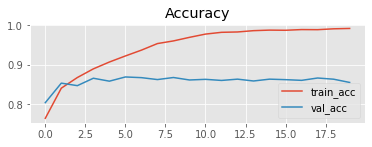

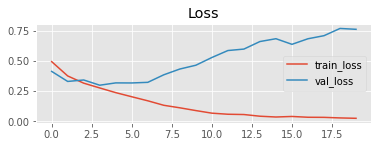

In [37]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(num_epochs)

plt.subplot(2,1,1)
plt.plot(epochs,train_accuracy)
plt.plot(epochs,val_accuracy)
plt.legend(['train_acc','val_acc'])
plt.title('Accuracy')
plt.show()

plt.subplot(2,1,2)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.legend(['train_loss','val_loss'])
plt.title('Loss')
plt.show()

In [39]:
sentence = ["Coworkers At Bathroom Sink Locked In Tense Standoff Over Who Going To Wash Hands Longer", 
            "Spiking U.S. coronavirus cases could force rationing decisions similar to those made in Italy, China."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[1.       ]
 [0.9419445]]
